In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.pipeline import Pipeline

from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN

from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV, train_test_split, RepeatedStratifiedKFold, cross_val_score, learning_curve
from sklearn.metrics import classification_report, fbeta_score, confusion_matrix, precision_recall_curve, auc, make_scorer

In [2]:
accepted_loans = pd.read_csv('../input/elitedata/elite.csv')

In [3]:
X = accepted_loans.loc[:, accepted_loans.columns != 'loan_paid'].values
y = accepted_loans['loan_paid'].values

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [5]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)

In [6]:
minmax_scaler = ('minmax', MinMaxScaler())

In [7]:
smote = ('smote', SMOTE(sampling_strategy=1.0, random_state=42))
smote_param_grid = {
    'smote__sampling_strategy': [0.8, 0.9, 1.0]
    #'smote__k_neighbors': [3, 5, 10, 15]
}

In [8]:
lr = ('lr', LogisticRegression())
lr_param_grid = {
    'lr__C': [0.01, 0.1, 1, 10, 100],
    'lr__penalty': ['l2'],
    'lr__max_iter': [100, 500],
    'lr__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

In [9]:
# Metric
f_onehalf_scorer = make_scorer(fbeta_score, beta=0.5)

In [10]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=cv,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    if axes is None:
        _, axes = plt.subplots(3, 1, figsize=(15, 15))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        scoring=f_onehalf_scorer,
        return_times=True,
        random_state=42
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times") 
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [11]:
def pooled_var(stds):
    n = 5 # size of each group
    return np.sqrt(sum((n-1)*(stds**2))/ len(stds)*(n-1))

def plot_search_results(search):
  df = pd.DataFrame(search.cv_results_)
  results = ['mean_test_score',
            'mean_train_score',
            'std_test_score', 
            'std_train_score']

  fig, axes = plt.subplots(1, len(param_grid), 
                          figsize = (10*len(param_grid), 7),
                          sharey='row')
  axes[0].set_ylabel("Score", fontsize=25)


  for idx, (param_name, param_range) in enumerate(param_grid.items()):
      grouped_df = df.groupby(f'param_{param_name}')[results]\
          .agg({'mean_train_score': 'mean',
                'mean_test_score': 'mean',
                'std_train_score': pooled_var,
                'std_test_score': pooled_var})

      previous_group = df.groupby(f'param_{param_name}')[results]
      axes[idx].set_xlabel(param_name, fontsize=30)
      axes[idx].set_ylim(0.0, 1.1)
      lw = 2
      axes[idx].plot(param_range, grouped_df['mean_train_score'], label="Training score",
                  color="darkorange", lw=lw)
      axes[idx].fill_between(param_range,grouped_df['mean_train_score'] - grouped_df['std_train_score'],
                      grouped_df['mean_train_score'] + grouped_df['std_train_score'], alpha=0.2,
                      color="darkorange", lw=lw)
      axes[idx].plot(param_range, grouped_df['mean_test_score'], label="Cross-validation score",
                  color="navy", lw=lw)
      axes[idx].fill_between(param_range, grouped_df['mean_test_score'] - grouped_df['std_test_score'],
                      grouped_df['mean_test_score'] + grouped_df['std_test_score'], alpha=0.2,
                      color="navy", lw=lw)

  handles, labels = axes[0].get_legend_handles_labels()
  fig.suptitle('Validation curves', fontsize=40)
  fig.legend(handles, labels, loc=8, ncol=2, fontsize=20)

  fig.subplots_adjust(bottom=0.25, top=0.85)  
  plt.show()

In [12]:
def print_result_df(search):
  keeping_columns = ['params', 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score', 'mean_fit_time', 'std_fit_time']
  df = pd.DataFrame(search.cv_results_)
  df = df[keeping_columns].sort_values(by='mean_test_score', ascending=False)
  return df.iloc[:10, :]

In [13]:
def print_best_model_result(search, name):
  print("Best parameter (CV score=):" % search.best_score_)
  best_model = search.best_estimator_
  print(best_model)

  y_pred = best_model.predict(X_test)

  print(classification_report(y_test, y_pred))
  print(confusion_matrix(y_test, y_pred))
  
  f_onehalf_score = fbeta_score(y_test, y_pred, beta=0.5)
  print('f0.5_score=', f_onehalf_score)

  try :
    y_score = best_model.predict_proba(X_test)[:, 1]
    # calculate precision and recall for each threshold
    precision, recall, threshold = precision_recall_curve(y_test, y_score)
    # calculate scores
    pr_auc = auc(recall, precision)
    print('pr_auc_score=', pr_auc)

    # calculate the no skill line as the proportion of the positive class
    no_skill = len(y_test[y_test==1]) / len(y_test)
    # plot the no skill precision-recall curve
    plt.figure(figsize=(10, 7))
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    # plot the model precision-recall curve
    plt.plot(recall, precision, marker='.', label=name)
    plt.title(f'{name}(pr_auc={pr_auc})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
  except:
    pass

  plot_learning_curve(best_model, name, X_train, y_train, cv=cv, n_jobs=-1 )
  plt.show()

  return best_model

In [14]:
pipe = Pipeline(steps=[minmax_scaler, smote, lr])

In [15]:
param_grid = {**smote_param_grid, **lr_param_grid}

In [16]:
search = HalvingGridSearchCV(pipe, param_grid, scoring=f_onehalf_scorer, cv=cv, verbose=3, return_train_score=True)

In [17]:
search.fit(X_train, y_train)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 13267
max_resources_: 1074704
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 150
n_resources: 13267
Fitting 10 folds for each of 150 candidates, totalling 1500 fits
[CV 1/10] END lr__C=0.01, lr__max_iter=100, lr__penalty=l2, lr__solver=newton-cg, smote__sampling_strategy=0.8;, score=(train=0.905, test=0.897) total time=   0.3s
[CV 2/10] END lr__C=0.01, lr__max_iter=100, lr__penalty=l2, lr__solver=newton-cg, smote__sampling_strategy=0.8;, score=(train=0.901, test=0.894) total time=   0.3s
[CV 3/10] END lr__C=0.01, lr__max_iter=100, lr__penalty=l2, lr__solver=newton-cg, smote__sampling_strategy=0.8;, score=(train=0.901, test=0.897) total time=   0.3s
[CV 4/10] END lr__C=0.01, lr__max_iter=100, lr__penalty=l2, lr__solver=newton-cg, smote__sampling_strategy=0.8;, score=(train=0.900, test=0.891) total time=   0.3s
[CV 5/10] END lr__C=0.01, lr__max_iter=100, lr__penalty=l2, lr__solver=

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/10] END lr__C=1, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.932, test=0.923) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/10] END lr__C=1, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.929, test=0.924) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/10] END lr__C=1, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.928, test=0.928) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/10] END lr__C=1, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.931, test=0.925) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/10] END lr__C=1, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.927, test=0.923) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 6/10] END lr__C=1, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.927, test=0.932) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 7/10] END lr__C=1, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.928) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 8/10] END lr__C=1, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.928, test=0.930) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 9/10] END lr__C=1, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.930, test=0.926) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 10/10] END lr__C=1, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.929, test=0.929) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/10] END lr__C=1, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.932, test=0.923) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/10] END lr__C=1, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.929, test=0.923) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/10] END lr__C=1, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.927, test=0.930) total time=   0.4s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/10] END lr__C=1, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.931, test=0.923) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/10] END lr__C=1, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.927, test=0.925) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 6/10] END lr__C=1, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.926, test=0.931) total time=   0.4s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 7/10] END lr__C=1, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.933, test=0.925) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 8/10] END lr__C=1, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.928, test=0.927) total time=   0.4s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 9/10] END lr__C=1, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.931, test=0.926) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 10/10] END lr__C=1, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.927, test=0.927) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/10] END lr__C=1, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.930, test=0.923) total time=   0.4s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/10] END lr__C=1, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.928, test=0.922) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/10] END lr__C=1, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.926, test=0.930) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/10] END lr__C=1, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.930, test=0.923) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/10] END lr__C=1, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.927, test=0.924) total time=   0.4s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 6/10] END lr__C=1, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.926, test=0.929) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 7/10] END lr__C=1, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.931, test=0.924) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 8/10] END lr__C=1, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.927, test=0.926) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 9/10] END lr__C=1, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.928, test=0.925) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 10/10] END lr__C=1, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.926, test=0.926) total time=   0.3s
[CV 1/10] END lr__C=1, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear, smote__sampling_strategy=0.8;, score=(train=0.932, test=0.923) total time=   0.3s
[CV 2/10] END lr__C=1, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear, smote__sampling_strategy=0.8;, score=(train=0.930, test=0.924) total time=   0.3s
[CV 3/10] END lr__C=1, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear, smote__sampling_strategy=0.8;, score=(train=0.928, test=0.928) total time=   0.3s
[CV 4/10] END lr__C=1, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear, smote__sampling_strategy=0.8;, score=(train=0.931, test=0.925) total time=   0.3s
[CV 5/10] END lr__C=1, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear, smote__sampling_strategy=0.8;, score=(train=0.927, test=0.923) total time=   0.3s
[CV 6/10] END lr__C=1, lr__max_iter=1

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.935, test=0.926) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.935, test=0.927) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.932, test=0.935) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.935, test=0.926) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.932, test=0.929) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 6/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.931, test=0.936) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 7/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.936, test=0.930) total time=   0.4s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 8/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.931) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 9/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.935, test=0.928) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 10/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.934) total time=   0.4s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.935, test=0.928) total time=   0.4s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.934, test=0.928) total time=   0.6s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.931, test=0.937) total time=   0.5s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.935, test=0.927) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.932, test=0.928) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 6/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.931, test=0.933) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 7/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.936, test=0.930) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 8/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.933, test=0.928) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 9/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.934, test=0.927) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 10/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.932, test=0.933) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.934, test=0.928) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.933, test=0.927) total time=   0.4s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.929, test=0.934) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.935, test=0.927) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.930, test=0.927) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 6/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.930, test=0.932) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 7/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.936, test=0.929) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 8/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.932, test=0.928) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 9/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.933, test=0.925) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 10/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.933, test=0.932) total time=   0.3s
[CV 1/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear, smote__sampling_strategy=0.8;, score=(train=0.936, test=0.926) total time=   0.3s
[CV 2/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.928) total time=   0.5s
[CV 3/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear, smote__sampling_strategy=0.8;, score=(train=0.932, test=0.935) total time=   0.3s
[CV 4/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear, smote__sampling_strategy=0.8;, score=(train=0.936, test=0.927) total time=   0.4s
[CV 5/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear, smote__sampling_strategy=0.8;, score=(train=0.932, test=0.930) total time=   0.4s
[CV 6/10] END lr__C=10, lr__max

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 6/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.931, test=0.938) total time=   2.4s
[CV 7/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.936, test=0.930) total time=   1.8s
[CV 8/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.931) total time=   1.6s
[CV 9/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.929) total time=   1.8s
[CV 10/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.934) total time=   1.8s
[CV 1/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.9;, score=(train=0.935, test=0.928) total time=   1.9s
[CV 2/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2,

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.936, test=0.929) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.936, test=0.929) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.938) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.937, test=0.930) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.930) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 6/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.935) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 7/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.937, test=0.932) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 8/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.935, test=0.931) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 9/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.935, test=0.930) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 10/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.935, test=0.936) total time=   0.5s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.936, test=0.931) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.936, test=0.929) total time=   0.4s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.932, test=0.939) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.936, test=0.928) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.933, test=0.929) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 6/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.932, test=0.934) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 7/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.937, test=0.931) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 8/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.934, test=0.929) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 9/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.935, test=0.928) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 10/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.934, test=0.935) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.935, test=0.930) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.934, test=0.928) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.931, test=0.937) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.935, test=0.927) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.932, test=0.929) total time=   0.4s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 6/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.932, test=0.934) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 7/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.937, test=0.929) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 8/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.934, test=0.929) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 9/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.933, test=0.926) total time=   0.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 10/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.935, test=0.936) total time=   0.3s
[CV 1/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear, smote__sampling_strategy=0.8;, score=(train=0.936, test=0.928) total time=   0.6s
[CV 2/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear, smote__sampling_strategy=0.8;, score=(train=0.937, test=0.928) total time=   0.5s
[CV 3/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.937) total time=   0.4s
[CV 4/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear, smote__sampling_strategy=0.8;, score=(train=0.937, test=0.929) total time=   0.4s
[CV 5/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.931) total time=   0.4s
[CV 6/10] END lr__C=100, 

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.8;, score=(train=0.936, test=0.928) total time=   2.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.8;, score=(train=0.937, test=0.928) total time=   2.3s
[CV 3/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.937) total time=   1.8s
[CV 4/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.8;, score=(train=0.937, test=0.929) total time=   1.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.931) total time=   2.4s
[CV 6/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.936) total time=   1.9s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 7/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.8;, score=(train=0.937, test=0.931) total time=   2.4s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 8/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.8;, score=(train=0.935, test=0.932) total time=   2.4s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 9/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.8;, score=(train=0.936, test=0.930) total time=   2.4s
[CV 10/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.8;, score=(train=0.935, test=0.936) total time=   2.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.9;, score=(train=0.936, test=0.930) total time=   2.5s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.9;, score=(train=0.936, test=0.928) total time=   2.5s
[CV 3/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.9;, score=(train=0.932, test=0.939) total time=   1.9s
[CV 4/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.9;, score=(train=0.936, test=0.927) total time=   1.7s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.9;, score=(train=0.933, test=0.928) total time=   2.5s
[CV 6/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.9;, score=(train=0.933, test=0.936) total time=   1.7s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 7/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.9;, score=(train=0.938, test=0.933) total time=   2.6s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 8/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.9;, score=(train=0.934, test=0.929) total time=   2.6s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 9/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.9;, score=(train=0.935, test=0.929) total time=   2.5s
[CV 10/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.9;, score=(train=0.934, test=0.936) total time=   2.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=1.0;, score=(train=0.935, test=0.930) total time=   2.7s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=1.0;, score=(train=0.935, test=0.927) total time=   2.7s
[CV 3/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=1.0;, score=(train=0.931, test=0.938) total time=   1.9s
[CV 4/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=1.0;, score=(train=0.935, test=0.928) total time=   1.5s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=1.0;, score=(train=0.932, test=0.929) total time=   2.7s
[CV 6/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=1.0;, score=(train=0.932, test=0.934) total time=   2.0s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 7/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=1.0;, score=(train=0.938, test=0.930) total time=   2.7s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 8/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=1.0;, score=(train=0.934, test=0.929) total time=   2.6s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 9/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=1.0;, score=(train=0.933, test=0.926) total time=   2.5s
[CV 10/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=1.0;, score=(train=0.936, test=0.936) total time=   2.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.936, test=0.928) total time=   2.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.937, test=0.929) total time=   2.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.937) total time=   2.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.937, test=0.929) total time=   2.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.931) total time=   2.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 6/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.936) total time=   2.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 7/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.937, test=0.931) total time=   2.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 8/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.935, test=0.932) total time=   2.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 9/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.936, test=0.930) total time=   2.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 10/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.935, test=0.936) total time=   2.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.9;, score=(train=0.937, test=0.930) total time=   2.4s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.9;, score=(train=0.936, test=0.928) total time=   2.4s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.9;, score=(train=0.932, test=0.940) total time=   2.4s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.9;, score=(train=0.936, test=0.927) total time=   2.4s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.9;, score=(train=0.932, test=0.928) total time=   2.4s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 6/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.9;, score=(train=0.933, test=0.936) total time=   2.4s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 7/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.9;, score=(train=0.937, test=0.932) total time=   2.4s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 8/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.9;, score=(train=0.934, test=0.929) total time=   2.5s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 9/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.9;, score=(train=0.935, test=0.929) total time=   2.4s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 10/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.9;, score=(train=0.934, test=0.935) total time=   2.5s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=1.0;, score=(train=0.935, test=0.930) total time=   2.6s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=1.0;, score=(train=0.935, test=0.927) total time=   2.6s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=1.0;, score=(train=0.931, test=0.938) total time=   2.6s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=1.0;, score=(train=0.935, test=0.928) total time=   2.5s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=1.0;, score=(train=0.932, test=0.929) total time=   2.6s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 6/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=1.0;, score=(train=0.933, test=0.935) total time=   2.6s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 7/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=1.0;, score=(train=0.937, test=0.930) total time=   2.5s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 8/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=1.0;, score=(train=0.934, test=0.929) total time=   2.6s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 9/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=1.0;, score=(train=0.933, test=0.926) total time=   2.5s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 10/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=1.0;, score=(train=0.936, test=0.935) total time=   2.6s
[CV 1/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=newton-cg, smote__sampling_strategy=0.8;, score=(train=0.936, test=0.928) total time=   1.1s
[CV 2/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=newton-cg, smote__sampling_strategy=0.8;, score=(train=0.937, test=0.928) total time=   1.1s
[CV 3/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=newton-cg, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.937) total time=   1.1s
[CV 4/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=newton-cg, smote__sampling_strategy=0.8;, score=(train=0.937, test=0.929) total time=   1.1s
[CV 5/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=newton-cg, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.931) total time=   0.9s
[CV 6/10] END lr__C=100, l

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.937, test=0.928) total time=   1.6s
[CV 3/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.937) total time=   1.2s
[CV 4/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.937, test=0.929) total time=   1.2s
[CV 5/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.931) total time=   1.3s
[CV 6/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.936) total time=   1.3s
[CV 7/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.937, test=0.931) total time=   1.5s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 8/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.935, test=0.932) total time=   1.7s
[CV 9/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.936, test=0.930) total time=   1.6s
[CV 10/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.935, test=0.936) total time=   1.1s
[CV 1/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.936, test=0.930) total time=   1.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.936, test=0.928) total time=   1.2s
[CV 3/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.932, test=0.939) total time=   0.8s
[CV 4/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.936, test=0.928) total time=   0.7s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.933, test=0.928) total time=   1.2s
[CV 6/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.933, test=0.936) total time=   0.9s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 7/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.938, test=0.933) total time=   1.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 8/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.934, test=0.929) total time=   1.1s
[CV 9/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.935, test=0.929) total time=   1.1s
[CV 10/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.935, test=0.936) total time=   0.9s
[CV 1/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.935, test=0.930) total time=   1.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.935, test=0.927) total time=   1.2s
[CV 3/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.931, test=0.938) total time=   0.8s
[CV 4/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.935, test=0.928) total time=   0.8s
[CV 5/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.932, test=0.929) total time=   1.2s
[CV 6/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.932, test=0.934) total time=   1.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 7/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.938, test=0.930) total time=   1.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 8/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.934, test=0.929) total time=   1.2s
[CV 9/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.933, test=0.926) total time=   1.1s
[CV 10/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.936, test=0.936) total time=   1.0s
[CV 1/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=liblinear, smote__sampling_strategy=0.8;, score=(train=0.936, test=0.928) total time=   0.6s
[CV 2/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=liblinear, smote__sampling_strategy=0.8;, score=(train=0.937, test=0.928) total time=   0.5s
[CV 3/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=liblinear, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.937) total time=   0.4s
[CV 4/10] END lr__C=100, lr__max_

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.931, test=0.931) total time=   1.6s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.932, test=0.928) total time=   1.7s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.933, test=0.933) total time=   1.7s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.934, test=0.931) total time=   1.6s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.932, test=0.934) total time=   1.6s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 6/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.933, test=0.933) total time=   1.6s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 7/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.932, test=0.930) total time=   1.7s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 8/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.932, test=0.931) total time=   1.5s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 9/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.933, test=0.932) total time=   1.7s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 10/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.933, test=0.931) total time=   1.6s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.932, test=0.932) total time=   1.6s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.931, test=0.929) total time=   1.7s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.932) total time=   1.7s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.935, test=0.931) total time=   1.6s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.932, test=0.934) total time=   1.6s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 6/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.934) total time=   1.5s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 7/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.932, test=0.930) total time=   1.6s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 8/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.932, test=0.930) total time=   1.9s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 9/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.932) total time=   1.6s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 10/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.930) total time=   1.6s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.931, test=0.931) total time=   1.7s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.932, test=0.928) total time=   1.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.933, test=0.932) total time=   1.7s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.934, test=0.931) total time=   1.6s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.932, test=0.933) total time=   1.7s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 6/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.933, test=0.934) total time=   1.7s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 7/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.932, test=0.931) total time=   1.7s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 8/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.933, test=0.930) total time=   1.7s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 9/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.932, test=0.931) total time=   1.7s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 10/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.932, test=0.930) total time=   1.6s
[CV 1/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=1.0;, score=(train=0.931, test=0.932) total time=  20.7s
[CV 2/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=1.0;, score=(train=0.933, test=0.928) total time=  13.0s
[CV 3/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=1.0;, score=(train=0.933, test=0.932) total time=  21.1s
[CV 4/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=1.0;, score=(train=0.935, test=0.930) total time=  11.7s
[CV 5/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=1.0;, score=(train=0.933, test=0.934) total time=  12.2s
[CV 6/10] END lr__C=100, lr__max_iter=500, lr__pen

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=1.0;, score=(train=0.931, test=0.932) total time=   8.7s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=1.0;, score=(train=0.933, test=0.928) total time=   8.7s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=1.0;, score=(train=0.933, test=0.932) total time=   8.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=1.0;, score=(train=0.934, test=0.930) total time=   8.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=1.0;, score=(train=0.933, test=0.934) total time=   9.0s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 6/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=1.0;, score=(train=0.933, test=0.933) total time=   8.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 7/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=1.0;, score=(train=0.932, test=0.930) total time=   8.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 8/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=1.0;, score=(train=0.933, test=0.930) total time=   8.7s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 9/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=1.0;, score=(train=0.933, test=0.931) total time=   8.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 10/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=1.0;, score=(train=0.932, test=0.930) total time=   9.0s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=1.0;, score=(train=0.931, test=0.932) total time=   9.2s
[CV 2/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=1.0;, score=(train=0.933, test=0.928) total time=   8.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=1.0;, score=(train=0.933, test=0.932) total time=   9.6s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=1.0;, score=(train=0.935, test=0.930) total time=   9.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=1.0;, score=(train=0.933, test=0.934) total time=   9.3s
[CV 6/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=1.0;, score=(train=0.933, test=0.933) total time=   7.0s
[CV 7/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=1.0;, score=(train=0.932, test=0.930) total time=   7.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 8/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=1.0;, score=(train=0.933, test=0.930) total time=   9.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 9/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=1.0;, score=(train=0.933, test=0.931) total time=   8.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 10/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=1.0;, score=(train=0.932, test=0.930) total time=   8.7s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.931, test=0.932) total time=   6.0s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.933, test=0.928) total time=   5.4s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.933, test=0.932) total time=   5.0s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.935, test=0.930) total time=   4.9s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.933, test=0.934) total time=   4.9s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 6/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.933, test=0.933) total time=   5.0s
[CV 7/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.932, test=0.930) total time=   4.4s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 8/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.933, test=0.930) total time=   5.0s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 9/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.933, test=0.931) total time=   4.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 10/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=1.0;, score=(train=0.932, test=0.930) total time=   4.6s
[CV 1/10] END lr__C=10, lr__max_iter=500, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.931, test=0.933) total time=   7.1s
[CV 2/10] END lr__C=10, lr__max_iter=500, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.931, test=0.930) total time=   6.5s
[CV 3/10] END lr__C=10, lr__max_iter=500, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.931) total time=   6.4s
[CV 4/10] END lr__C=10, lr__max_iter=500, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.935, test=0.931) total time=   6.5s
[CV 5/10] END lr__C=10, lr__max_iter=500, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.932, test=0.935) total time=   6.2s
[CV 6/10] END lr__C=10, lr__max_iter=500, lr__penalty=l

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.931, test=0.932) total time=   1.9s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.932, test=0.928) total time=   2.0s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.933, test=0.933) total time=   1.9s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.935, test=0.931) total time=   2.0s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.933, test=0.935) total time=   1.9s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 6/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.934, test=0.933) total time=   1.9s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 7/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.933, test=0.930) total time=   1.9s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 8/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.933, test=0.931) total time=   1.9s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 9/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.933, test=0.932) total time=   2.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 10/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.933, test=0.932) total time=   2.0s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.9;, score=(train=0.931, test=0.932) total time=   8.7s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.9;, score=(train=0.933, test=0.929) total time=   8.5s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.9;, score=(train=0.934, test=0.933) total time=   8.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.9;, score=(train=0.935, test=0.931) total time=   8.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.9;, score=(train=0.933, test=0.935) total time=   8.9s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 6/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.9;, score=(train=0.934, test=0.934) total time=   8.5s
[CV 7/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.9;, score=(train=0.932, test=0.930) total time=   8.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 8/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.9;, score=(train=0.933, test=0.932) total time=   8.7s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 9/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.9;, score=(train=0.933, test=0.932) total time=   8.6s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 10/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.9;, score=(train=0.933, test=0.932) total time=   8.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.9;, score=(train=0.931, test=0.932) total time=   8.8s
[CV 2/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.9;, score=(train=0.932, test=0.929) total time=   8.4s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.9;, score=(train=0.934, test=0.933) total time=   8.7s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.9;, score=(train=0.935, test=0.932) total time=   8.7s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.9;, score=(train=0.933, test=0.935) total time=   8.7s
[CV 6/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.9;, score=(train=0.934, test=0.934) total time=   7.0s
[CV 7/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.9;, score=(train=0.932, test=0.930) total time=   5.7s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 8/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.9;, score=(train=0.933, test=0.932) total time=   8.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 9/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.9;, score=(train=0.933, test=0.932) total time=   8.7s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 10/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.9;, score=(train=0.933, test=0.932) total time=   8.4s
[CV 1/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.9;, score=(train=0.931, test=0.932) total time=  13.5s
[CV 2/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.9;, score=(train=0.932, test=0.929) total time=   8.4s
[CV 3/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.9;, score=(train=0.934, test=0.933) total time=  15.6s
[CV 4/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.9;, score=(train=0.935, test=0.932) total time=   8.9s
[CV 5/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.9;, score=(train=0.933, test=0.935) total time=  10.1s
[CV 6/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.931, test=0.932) total time=   4.5s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.933, test=0.929) total time=   4.6s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.934, test=0.933) total time=   4.4s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.935, test=0.932) total time=   4.9s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.933, test=0.935) total time=   4.5s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 6/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.934, test=0.934) total time=   4.4s
[CV 7/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.933, test=0.930) total time=   3.7s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 8/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.933, test=0.932) total time=   4.7s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 9/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.933, test=0.932) total time=   4.6s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 10/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.9;, score=(train=0.933, test=0.932) total time=   4.4s
[CV 1/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=liblinear, smote__sampling_strategy=0.9;, score=(train=0.931, test=0.932) total time=   2.8s
[CV 2/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=liblinear, smote__sampling_strategy=0.9;, score=(train=0.933, test=0.929) total time=   2.9s
[CV 3/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=liblinear, smote__sampling_strategy=0.9;, score=(train=0.934, test=0.933) total time=   3.0s
[CV 4/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=liblinear, smote__sampling_strategy=0.9;, score=(train=0.935, test=0.932) total time=   2.8s
[CV 5/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=liblinear, smote__sampling_strategy=0.9;, score=(train=0.933, test=0.935) total time=   2.8s
[CV 6/10] END lr__C=100, 

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.8;, score=(train=0.932, test=0.933) total time=   8.4s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.8;, score=(train=0.931, test=0.930) total time=   8.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.932) total time=   8.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.8;, score=(train=0.935, test=0.932) total time=   8.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.935) total time=   8.1s
[CV 6/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.933) total time=   6.8s
[CV 7/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.8;, score=(train=0.932, test=0.931) total time=   3.6s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 8/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.931) total time=   8.0s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 9/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.933) total time=   8.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 10/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.932) total time=   8.0s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.932, test=0.933) total time=   4.5s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.931, test=0.930) total time=   4.6s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.932) total time=   4.6s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.935, test=0.932) total time=   4.7s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.935) total time=   4.4s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 6/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.933) total time=   4.4s
[CV 7/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.932, test=0.931) total time=   3.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 8/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.931) total time=   4.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 9/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.933) total time=   4.4s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 10/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.932) total time=   4.4s
[CV 1/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.932, test=0.933) total time=  17.9s
[CV 2/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.931, test=0.930) total time=  13.1s
[CV 3/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.932) total time=  19.8s
[CV 4/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.935, test=0.932) total time=  10.9s
[CV 5/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.935) total time=  10.0s
[CV 6/10] END lr__C=100, lr__max_iter=500, lr__pen

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.932, test=0.933) total time=   8.0s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.931, test=0.930) total time=   8.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.932) total time=   7.9s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.935, test=0.932) total time=   7.9s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.935) total time=   8.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 6/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.933) total time=   8.3s
[CV 7/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.932, test=0.931) total time=   7.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 8/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.931) total time=   8.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 9/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.933) total time=   8.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 10/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.932) total time=   8.0s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.931, test=0.932) total time=   1.5s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.932, test=0.930) total time=   1.6s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.932) total time=   1.5s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.935, test=0.932) total time=   1.5s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.935) total time=   1.6s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 6/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.933) total time=   1.5s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 7/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.932, test=0.931) total time=   1.5s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 8/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.931) total time=   1.4s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 9/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.933) total time=   1.5s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 10/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.931) total time=   1.5s
----------
iter: 2
n_candidates: 17
n_resources: 119403
Fitting 10 folds for each of 17 candidates, totalling 170 fits


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.9;, score=(train=0.933, test=0.931) total time=  31.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.9;, score=(train=0.934, test=0.934) total time=  31.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.9;, score=(train=0.934, test=0.933) total time=  31.4s
[CV 4/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.9;, score=(train=0.934, test=0.934) total time=  19.7s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.9;, score=(train=0.932, test=0.933) total time=  30.9s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 6/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.9;, score=(train=0.934, test=0.934) total time=  30.7s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 7/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.9;, score=(train=0.933, test=0.933) total time=  31.4s
[CV 8/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.9;, score=(train=0.933, test=0.932) total time=  18.2s
[CV 9/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.9;, score=(train=0.932, test=0.933) total time=  28.0s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 10/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.9;, score=(train=0.932, test=0.933) total time=  30.6s
[CV 1/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=newton-cg, smote__sampling_strategy=0.9;, score=(train=0.933, test=0.931) total time=  28.6s
[CV 2/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=newton-cg, smote__sampling_strategy=0.9;, score=(train=0.934, test=0.934) total time=  29.6s
[CV 3/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=newton-cg, smote__sampling_strategy=0.9;, score=(train=0.934, test=0.933) total time=  21.4s
[CV 4/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=newton-cg, smote__sampling_strategy=0.9;, score=(train=0.934, test=0.934) total time=  22.6s
[CV 5/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=newton-cg, smote__sampling_strategy=0.9;, score=(train=0.932, test=0.933) total time=  25.6s
[CV 6/10] END lr__C=100, l

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.9;, score=(train=0.933, test=0.931) total time=  32.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.9;, score=(train=0.934, test=0.934) total time=  31.2s
[CV 3/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.9;, score=(train=0.934, test=0.933) total time=  26.4s
[CV 4/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.9;, score=(train=0.934, test=0.934) total time=  16.0s
[CV 5/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.9;, score=(train=0.932, test=0.933) total time=  23.9s
[CV 6/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.9;, score=(train=0.934, test=0.934) total time=  26.6s
[CV 7/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.9;, score=(train=0.933, test=0.933) total time=  25.5s
[CV 8/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2,

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.932) total time=  29.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.935) total time=  30.1s
[CV 3/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.933) total time=  25.4s
[CV 4/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.934) total time=  14.7s
[CV 5/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.934) total time=  24.8s
[CV 6/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.934) total time=  26.3s
[CV 7/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.933) total time=  24.7s
[CV 8/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2,

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 10/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.933) total time=  29.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.931) total time=  17.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.935) total time=  16.5s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.933) total time=  22.4s
[CV 4/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.934) total time=  20.5s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.934) total time=  21.6s
[CV 6/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.934) total time=  17.0s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 7/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.933) total time=  21.4s
[CV 8/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.932) total time=  15.0s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 9/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.932, test=0.933) total time=  17.0s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 10/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.933) total time=  21.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.932) total time=  29.6s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.935) total time=  30.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.933) total time=  30.2s
[CV 4/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.934) total time=  20.6s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.934) total time=  30.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 6/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.934) total time=  30.4s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 7/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.933) total time=  30.1s
[CV 8/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.932) total time=  18.0s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 9/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.932, test=0.933) total time=  30.9s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 10/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.933) total time=  30.4s
[CV 1/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=liblinear, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.932) total time=  13.7s
[CV 2/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=liblinear, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.935) total time=  13.2s
[CV 3/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=liblinear, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.933) total time=  11.3s
[CV 4/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=liblinear, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.934) total time=  12.9s
[CV 5/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=liblinear, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.934) total time=  13.1s
[CV 6/10] END lr__C=100, l

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.933) total time= 1.6min


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.933) total time= 1.6min


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.935) total time= 1.5min


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.933) total time= 1.4min


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.934) total time= 1.5min


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 6/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.933) total time= 1.4min


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 7/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.933) total time= 1.4min


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 8/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.933) total time= 1.6min


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 9/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.933) total time= 1.4min


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 10/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.934) total time= 1.5min
[CV 1/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.933) total time= 1.6min
[CV 2/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.933) total time= 1.6min
[CV 3/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.934) total time= 2.2min
[CV 4/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.933) total time= 1.3min
[CV 5/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.934) total time= 1.4min


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 6/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.933) total time= 2.2min
[CV 7/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.933) total time= 1.4min
[CV 8/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.933) total time= 2.0min
[CV 9/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.933) total time= 1.7min
[CV 10/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.934) total time= 1.5min
[CV 1/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=saga, smote__sampling_strategy=0.8;, score=(train=0.934, test=0.933) total time= 1.6min
[CV 2/10] END lr__C=100, lr__max_iter=500, lr__pena

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.934) total time=10.2min


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.933) total time=10.2min


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.934) total time= 9.9min


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.933) total time=10.1min


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.934) total time=10.3min


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 6/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.933) total time=10.1min


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 7/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.934) total time=10.0min


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 8/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.933) total time= 9.6min


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 9/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.933) total time=10.3min


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 10/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.934) total time=10.7min
[CV 1/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=newton-cg, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.934) total time=24.7min


/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 2/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=newton-cg, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.933) total time=20.4min
[CV 3/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=newton-cg, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.934) total time=22.0min
[CV 4/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=newton-cg, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.933) total time=23.1min
[CV 5/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=newton-cg, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.934) total time=17.3min
[CV 6/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=newton-cg, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.933) total time=22.2min
[CV 7/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=newton-cg, smote__sampling_strategy=0.8;, score=(train=0.933, test=0.934) total time=17.3min
[CV 8/10] END lr__C=10

HalvingGridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=42),
                    estimator=Pipeline(steps=[('minmax', MinMaxScaler()),
                                              ('smote',
                                               SMOTE(random_state=42,
                                                     sampling_strategy=1.0)),
                                              ('lr', LogisticRegression())]),
                    param_grid={'lr__C': [0.01, 0.1, 1, 10, 100],
                                'lr__max_iter': [100, 500],
                                'lr__penalty': ['l2'],
                                'lr__solver': ['newton-cg', 'lbfgs',
                                               'liblinear', 'sag', 'saga'],
                                'smote__sampling_strategy': [0.8, 0.9, 1.0]},
                    scoring=make_scorer(fbeta_score, beta=0.5), verbose=3)

In [18]:
print_result_df(search)

,params,mean_train_score,std_train_score,mean_test_score,std_test_score,mean_fit_time,std_fit_time
217,"{'lr__C': 100, 'lr__max_iter': 500, 'lr__penal...",0.933286,0.000268,0.933425,0.000410,133.473057,24.914387
220,"{'lr__C': 100, 'lr__max_iter': 500, 'lr__penal...",0.933292,0.000272,0.933424,0.000426,89.367737,5.114026
221,"{'lr__C': 100, 'lr__max_iter': 100, 'lr__penal...",0.933286,0.000268,0.933423,0.000412,102.757270,17.841762
222,"{'lr__C': 100, 'lr__max_iter': 500, 'lr__penal...",0.933286,0.000269,0.933423,0.000411,102.741250,19.554909
219,"{'lr__C': 100, 'lr__max_iter': 100, 'lr__penal...",0.933286,0.000273,0.933420,0.000404,74.610584,3.945404
218,"{'lr__C': 100, 'lr__max_iter': 500, 'lr__penal...",0.933286,0.000273,0.933420,0.000404,73.928633,3.800149
224,"{'lr__C': 100, 'lr__max_iter': 500, 'lr__penal...",0.933317,0.000084,0.933289,0.000331,1293.095583,164.079785
223,"{'lr__C': 100, 'lr__max_iter': 500, 'lr__penal...",0.933323,0.000087,0.933284,0.000330,608.095531,16.150545
210,"{'lr__C': 100, 'lr__max_iter': 500, 'lr__penal...",0.933363,0.000672,0.933146,0.000899,33.907135,9.738738
214,"{'lr__C': 100, 'lr__max_iter': 100, 'lr__penal...",0.933360,0.000668,0.933143,0.000897,28.171098,4.490685


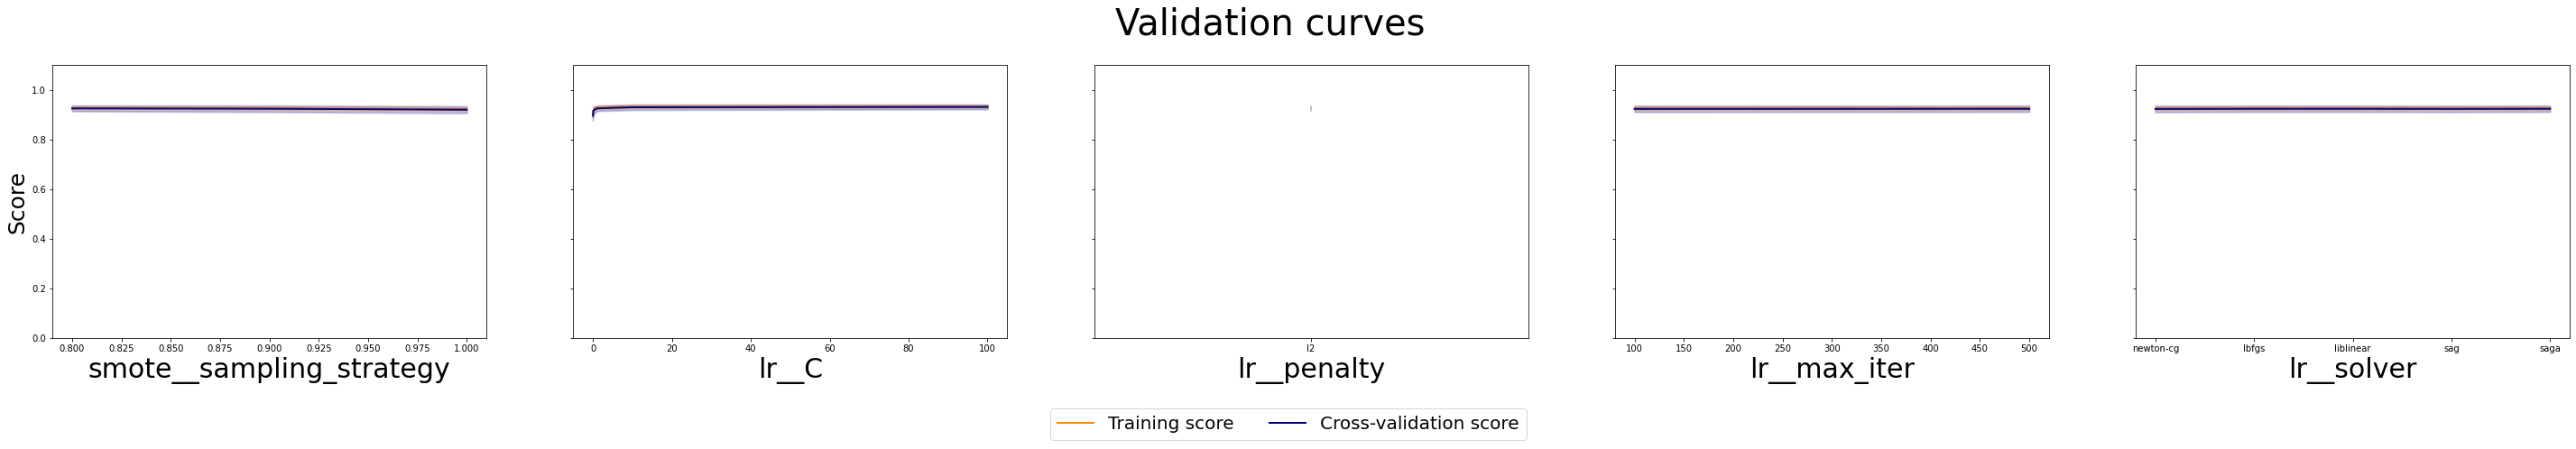

In [19]:
plot_search_results(search)

Best parameter (CV score=):
Pipeline(steps=[('minmax', MinMaxScaler()),
                ('smote', SMOTE(random_state=42, sampling_strategy=0.8)),
                ('lr',
                 LogisticRegression(C=100, max_iter=500, solver='newton-cg'))])
              precision    recall  f1-score   support

           0       0.54      0.91      0.68     53638
           1       0.97      0.81      0.88    215038

    accuracy                           0.83    268676
   macro avg       0.75      0.86      0.78    268676
weighted avg       0.89      0.83      0.84    268676

[[ 48627   5011]
 [ 41745 173293]]
f0.5_score= 0.9334352450945539
pr_auc_score= 0.9815043674359029


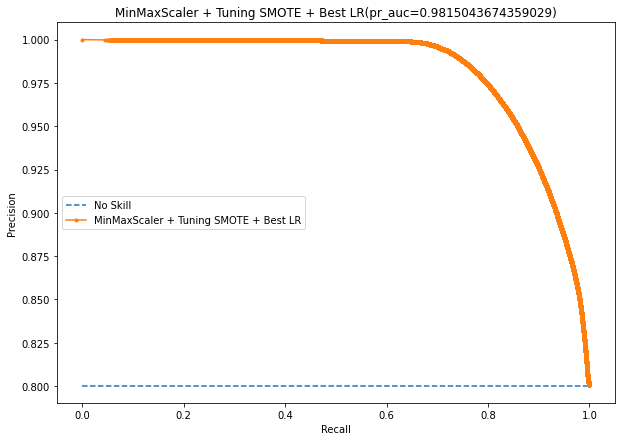

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGKILL(-9)}

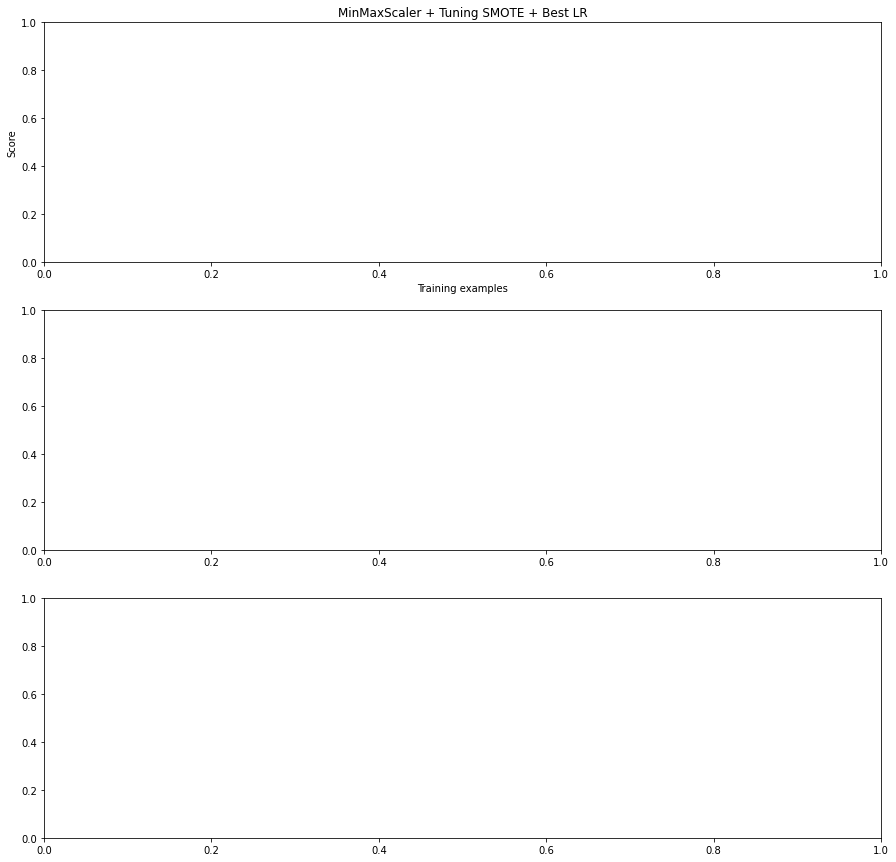

In [20]:
print_best_model_result(search, 'MinMaxScaler + Tuning SMOTE + Best LR')